<a href="https://colab.research.google.com/github/mjn6862/Freiburg_dataset/blob/master/Matthew_Copy_of_Warping_for_PoseNet_Freiburg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Statements**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tensorflow_graphics

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_graphics.geometry.transformation as tfg_transformation
from tensorflow import keras
from datetime import datetime
import csv
from matplotlib import pyplot as plt

**Custom Data Generator**

This works (I think) for giving two sequential images to a Keras Functional model as well as the velocity associated with the second image.

At this point, don't worry about how this works. If you need something changed or fixed, just ask. This is the boring part anyways.

In [2]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, custom_indices, batch_size=32,
                  shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.direct = "./drive/My Drive/Machine_Learning_Projects/freiburg_dataset/"
        self.indexes = custom_indices
        self.save_indices = custom_indices
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        index = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Find list of IDs
        # Generate data
        X, y = self.__data_generation(index)#batch)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = self.save_indices #np.arange(len(self.list_IDs)-5)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, names_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        x1_full = np.empty((0, 480, 640, 4))
        x2_full = np.empty((0, 480, 640, 4))
        y_full = np.empty((0, 4, 4))
        for name in names_temp:
          # Small hack due to off-by-one in the inidices
          x1 = np.load(self.direct+"/images/rgbd_%d.npy"%int(self.list_IDs[int(name[0])][0]))
          #print("%d, %d" %(int(self.list_IDs[int(name[0])][0]), int(self.list_IDs[int(name[0])+4][0])))
          x1 = np.reshape(x1,(1,480, 640, 4))
          x2 = np.load(self.direct+"images/rgbd_%d.npy"%int(self.list_IDs[int(name[0])+4][0]))
          x2 = np.reshape(x2,(1,480, 640, 4))
          x1 = x1/255.
          #x1 = x1 - np.mean(x1, axis=0)
          x2 = x2/255.
          #x2 = x2 - np.mean(x2, axis=0)
          depth1 = x1[0,:,:,3]*5.
          depth1 = np.where(depth1==0,10.,depth1)
          depth2 = x2[0,:,:,3]*5
          depth2 = np.where(depth2==0,10.,depth2)
          x1[0,:,:,3] = depth1
          x2[0,:,:,3] = depth2
          y1 = np.load(self.direct+"pose/htm_%d.npy"%int(self.list_IDs[int(name[0])][0]))
          y2 = np.load(self.direct+"pose/htm_%d.npy"%int(self.list_IDs[int(name[0])+4][0]))
          #y = np.linalg.inv(y1).dot(y2) # Use this if the poses are camera in world frame
          #y = y1.dot(np.linalg.inv(y2)) # Use this if the poses are world in camera frame
          x1_full = np.concatenate((x1_full, x1))
          x2_full = np.concatenate((x2_full, x2))
          #y_full = np.concatenate((y_full, np.reshape(y, (1, 4, 4)) ))
        #y_quat = tfg_transformation.quaternion.from_rotation_matrix(y_full[:,0:3, 0:3])
        #y_quat = np.arccos(y_quat[:,3]).reshape((-1,1))*y_quat[:,0:3]/np.linalg.norm(y_quat[:,0:3], axis=1).reshape((-1,1))
        #total = tf.keras.layers.concatenate((y_quat, y_full[:,0:3,3]), dtype='float64')
        # here
        return  [x1_full[:,:,:,0:3], x1_full[:,:,:,3], x2_full[:,:,:,0:3], x2_full[:,:,:,3]],[x2_full[:,:,:,0:3]]

**Define the test-train split and create the Data Generator**

In [3]:
def make_generator(indices_filename):
  with open('./drive/My Drive/Machine_Learning_Projects/freiburg_dataset/all_frame_ids.csv', newline='') as f:
    reader = csv.reader(f)
    list_IDs = list(reader)
  with open(indices_filename, newline='') as f:
    reader = csv.reader(f)
    indices = list(reader)
  indices = np.asarray(indices)
  return DataGenerator(list_IDs = list_IDs, custom_indices = indices, batch_size=16, shuffle=True )

In [4]:
train_filename = './drive/My Drive/Machine_Learning_Projects/freiburg_dataset/training_indices.csv'
valid_filename = './drive/My Drive/Machine_Learning_Projects/freiburg_dataset/validation_indices.csv'

training_generator = make_generator(train_filename)
validation_generator = make_generator(valid_filename)

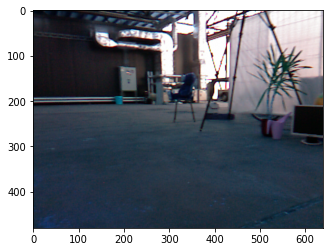

In [5]:
plt.imshow(training_generator[1][1][0][0])

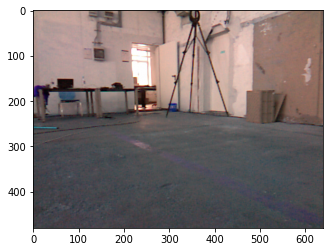

In [6]:
plt.imshow(training_generator[0][1][0][15])

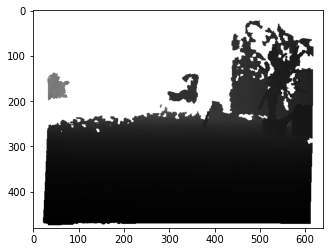

In [7]:
plt.imshow(training_generator[1][0][3][0],cmap='gray')

In [8]:
input_A = tf.keras.layers.Input(shape=(480, 640, 3), name="first_image")
depth_A = tf.keras.layers.Input(shape=(480, 640, 1), name="first_depth")
input_B = tf.keras.layers.Input(shape=(480, 640, 3), name="second_image")
depth_B = tf.keras.layers.Input(shape=(480, 640, 1), name="second_depth")

In [9]:
out_dim = 6
concat = tf.keras.layers.concatenate([input_A, input_B],name='concat')
conv1 = tf.keras.layers.Conv2D(16,(7, 7), padding='same', strides=(2, 2), activation='relu',name='conv1')(concat)
conv2 = tf.keras.layers.Conv2D(32, (5, 5), padding='same', strides=(2, 2), activation='relu',name='conv2')(conv1)
readout = tf.keras.layers.Conv2D(out_dim, (1, 1),name='readout')(conv2)
readout2 = tf.keras.layers.GlobalAveragePooling2D(name='readout2')(readout)
input_pose = tf.keras.layers.Flatten(name='input_pose')(readout2)

In [10]:
# create 3x3 matrix omega_x from xi=[omega nu]
omega_x_weights = np.zeros([6,9])
omega_x_weights[0,5]=-1
omega_x_weights[0,7]=1
omega_x_weights[1,2]=1
omega_x_weights[1,6]=-1
omega_x_weights[2,1]=-1
omega_x_weights[2,3]=1

omega_x = tf.keras.layers.Dense(9,use_bias=False,weights=[omega_x_weights],trainable=False,name='omega_x1')(input_pose)
omega_x = tf.keras.layers.Reshape((3,3),name='omega_x2')(omega_x)

In [11]:
# create 3-dimensional vector nu from xi=[omega nu]
nu_weights = np.zeros([6,3])
nu_weights[3,0]=1
nu_weights[4,1]=1
nu_weights[5,2]=1

nu = tf.keras.layers.Dense(3,use_bias=False,weights=[nu_weights],trainable=False,name='nu')(input_pose)

In [12]:
# get ||omega|| from xi
def om_norm_fun(xi):
  return tf.norm(xi[0:3])
om_norm = tf.keras.layers.Lambda(om_norm_fun,name='om_norm')(input_pose)

In [13]:
# get omega_x**2
omega_x_squared = tf.keras.layers.Dot(axes=(1,2),name='omega_x_squared')([omega_x,omega_x])

In [14]:
# get terms for exp(omega_x) and V
# exp(omega_x) = I + term1 + term2 in (2.21)
def term1_fun(x):
  return tf.sin(x[1])/tf.math.maximum(x[1],1e-16)*x[0] #tf.math.maximum to avoid dividing by 0
term1 = tf.keras.layers.Lambda(term1_fun,name='term1')((omega_x,om_norm))

def term2_fun(x):
  return (1-tf.cos(x[1]))/tf.math.maximum(x[1],1e-16)**2*x[0] #tf.math.maximum to avoid dividing by 0
term2 = tf.keras.layers.Lambda(term2_fun,name='term2')((omega_x_squared,om_norm))

# V = I + term3 + term4 in (2.22)
def term3_fun(x):
  return (1-tf.cos(x[1]))/tf.math.maximum(x[1],1e-16)**2*x[0] #tf.math.maximum to avoid dividing by 0
term3 = tf.keras.layers.Lambda(term3_fun,name='term3')((omega_x,om_norm))

def term4_fun(x):
  return (x[1]-tf.sin(x[1]))/tf.math.maximum(x[1],1e-16)**3*x[0] #tf.math.maximum to avoid dividing by 0
term4 = tf.keras.layers.Lambda(term4_fun,name='term4')((omega_x_squared,om_norm))

In [15]:
# get exp(omega_x)
# exp_om_x = I + term1 + term2
exp_om_x = tf.keras.layers.add([term1,term2],name='exp_om_x1')
# still need to add I.  There might be a more elegant way, but I'm going to do 
# this by using a Dense layer and specifying the weights
exp_om_x = tf.keras.layers.Flatten()(exp_om_x)
# use identity for weights to keep the same, then use np.array([1,0,0,0,1,0,0,0,1]) to add identity matrix to exp_om_x
exp_om_x = tf.keras.layers.Dense(9,weights=[np.eye(9),np.array([1,0,0,0,1,0,0,0,1])],trainable=False,name='exp_om_x2')(exp_om_x)
exp_om_x = tf.keras.layers.Reshape((3,3),name='exp_om_x3')(exp_om_x)

In [16]:
# Get V and V*nu
# V = I + term3 + term4
V = tf.keras.layers.add([term3,term4],name='V1')
# still need to add I.  There might be a more elegant way, but I'm going to do 
# this by using a Dense layer and specifying the weights
V = tf.keras.layers.Flatten(name='V2')(V)
# use identity for weights to keep the same, then use np.array([1,0,0,0,1,0,0,0,1]) to add identity matrix to exp_om_x
V = tf.keras.layers.Dense(9,weights=[np.eye(9),np.array([1,0,0,0,1,0,0,0,1])],trainable=False,name='V3')(V) 
V = tf.keras.layers.Reshape((3,3),name='V4')(V)
# get V*nu
V_nu = tf.keras.layers.Dot(axes=(2,1),name='V_nu1')([V,nu])
V_nu = tf.keras.layers.Reshape((3,1),name='V_nu2')(V_nu)

In [17]:
# get exp_xi by concatenating exp_om_x and V_nu, then concatenate a bottom row of [0,0,0,1]
exp_xi = tf.keras.layers.concatenate([exp_om_x,V_nu],name='exp_xi1')
# this is a silly way to get a bottom row of [0,0,0,1], but it works
bottom_row = tf.keras.layers.Dense(4,weights=[np.zeros([6,4]),np.array([0,0,0,1])],trainable=False,name='bottom_row1')(input_pose)
bottom_row = tf.keras.layers.Reshape((1,4),name='bottom_row2')(bottom_row)

exp_xi = tf.keras.layers.concatenate([exp_xi,bottom_row],axis=1,name='exp_xi2')

In [18]:
# Define hx, wx, h1 as the homogeneous pixel coordinates
# This appears to match the original paper's output format
height_coord = range(480)
width_coord = range(640)
hx, wx = pixel_coord = np.meshgrid(height_coord, width_coord, indexing='ij')
hx = hx.reshape((480, 640, 1))
wx = wx.reshape((480, 640, 1))
h1 = np.ones(hx.shape)

grid = np.concatenate((hx, wx, h1), axis=-1)

# Define the camera intrinsic matrix
#K = np.array([[525.,0.,319.5], [0., 525., 239.5], [0.,0.,1.]])  # This is how the rostopic defines it
K = np.array([[525.,0.,239.5], [0., 525., 319.5], [0.,0.,1.]])

# Define the camera coordinates of each piel up to a depth scale factor
unscaled_cam_coord = np.empty(grid.shape)
for i in range(480):
      for j in range(640):
        unscaled_cam_coord[i,j,:]= np.linalg.inv(K).dot(grid[i,j,:])

In [19]:
camera_coord = tf.keras.layers.Reshape((307200,1),name='camera_coord1')(depth_A)
def camera_coord_fun(depth):
  return depth*unscaled_cam_coord.reshape(307200,3)
  
camera_coord = tf.keras.layers.Lambda(camera_coord_fun,name='camera_coord2')(camera_coord)

In [20]:
# Here's an annoying way to get an output of all ones.  I used a layer with 1 neuron as an intermediary to avoid too many weights
ones_layer = tf.keras.layers.Flatten(name='ones1')(depth_A)
ones_layer = tf.keras.layers.Dense(1,use_bias=False,weights=[np.zeros([307200,1])],trainable=False,name='ones2')(ones_layer)
ones_layer = tf.keras.layers.Dense(307200,weights=[np.zeros([1,307200]),np.ones(307200)],trainable=False,name='ones3')(ones_layer)
ones_layer = tf.keras.layers.Reshape((307200,1),name='ones4')(ones_layer)

In [21]:
homog_camera_coord = tf.keras.layers.concatenate([camera_coord, ones_layer],name='homog_camera_coord')

In [22]:
 # new_homog_camera_coord = tf.keras.backend.dot(homog_camera_coord, tf.keras.backend.transpose(tf.reshape(delta_pose,(4,4))))
 # new_homog_camera_coord = tf.math.divide(new_homog_camera_coord, tf.reshape(new_homog_camera_coord[:,2], (307200,1)) ) 
 new_homog_camera_coord = tf.keras.layers.Dot(axes=(2,2),name='new_homog_camera_coord1')([homog_camera_coord,exp_xi]) # not sure if axes value is correct, but the output has all ones on the right side, so it's probably right

 new_coord_depth1 = tf.keras.layers.Lambda(lambda coord: coord[:,:,2],name='new_coord_depth1')(new_homog_camera_coord)
 new_coord_depth2 = tf.keras.layers.Reshape((307200,1),name='new_coord_depth2')(new_coord_depth1)
 def new_homog_camera_coord_fun(x):
   return tf.math.divide(x[0],x[1])
new_homog_camera_coord = tf.keras.layers.Lambda(new_homog_camera_coord_fun,name='new_homog_camera_coord2')((new_homog_camera_coord,new_coord_depth2))
new_homog_camera_coord = tf.keras.layers.Lambda(lambda coord: coord[:,:,0:3],name='new_homog_camera_coord3')(new_homog_camera_coord)

In [23]:
#  pixel_list = tf.keras.backend.dot(tf.reshape(new_homog_camera_coord[:,0:3],(307200,3)), tf.keras.backend.transpose(K))
# I guess I need to create a layer corresponding to K first
# I used a layer with 1 neuron as an intermediary to avoid too many weights
K_layer = tf.keras.layers.Flatten(name='K1')(depth_A)
K_layer = tf.keras.layers.Dense(1,use_bias=False,weights=[np.zeros([307200,1])],trainable=False,name='K2')(K_layer)
K_layer = tf.keras.layers.Dense(9,weights=[np.zeros([1,9]),K.reshape(9)],trainable=False,name='K3')(K_layer)
K_layer = tf.keras.layers.Reshape((3,3),name='K4')(K_layer)

pixel_list = tf.keras.layers.Dot(axes=(2,2),name='pixel_list1')([new_homog_camera_coord,K_layer]) # not sure if axes value is correct
pixel_list2 = tf.keras.layers.Lambda(lambda pix: pix[:,:,0:2],name='pixel_list2')(pixel_list)
#pixel_list = tf.keras.layers.Reshape((1,307200,2))(pixel_list)

In [24]:
# interp = tfa.image.interpolate_bilinear(grid=tf.reshape(image1[-1, :, :, :], (1, 480, 640,3)), query_points=tf.reshape(pixel_list[:,0:2], (-1,307200,2)))
def interp_fun(x):
  return tfa.image.interpolate_bilinear(grid=tf.reshape(x[0],(-1,480,640,3)),query_points=tf.reshape(x[1],(-1,307200,2)))
interp = tf.keras.layers.Lambda(interp_fun,name='interp')((input_A,pixel_list2))
new_image = tf.keras.layers.Reshape((480,640,3),name='new_image')(interp)

In [25]:
model = tf.keras.models.Model(inputs=[input_A,depth_A,input_B,depth_B],outputs=[new_image])

In [26]:
preds = model.predict(training_generator[0])

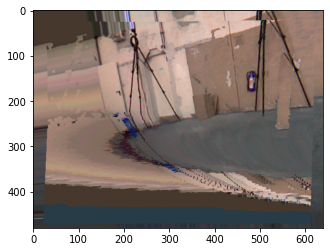

In [27]:
plt.imshow(preds[2])

In [28]:
_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=_optimizer, loss ='mse')# metrics = metric_mean)

In [29]:
model.fit(training_generator, epochs=10, verbose=1, validation_data=validation_generator)

Epoch 1/10
69/69 [==============================] - 488s 7s/step - loss: 0.0249 - val_loss: 0.0228
Epoch 2/10
69/69 [==============================] - 84s 1s/step - loss: 0.0212 - val_loss: 0.0224
Epoch 3/10
69/69 [==============================] - 85s 1s/step - loss: 0.0211 - val_loss: 0.0220
Epoch 4/10
69/69 [==============================] - 86s 1s/step - loss: 0.0208 - val_loss: 0.0221
Epoch 5/10
69/69 [==============================] - 87s 1s/step - loss: 0.0197 - val_loss: 0.0215
Epoch 6/10
69/69 [==============================] - 87s 1s/step - loss: 0.0187 - val_loss: 0.0191
Epoch 7/10
69/69 [==============================] - 88s 1s/step - loss: 0.0194 - val_loss: 0.0193
Epoch 8/10
69/69 [==============================] - 88s 1s/step - loss: 0.0185 - val_loss: 0.0186
Epoch 9/10
69/69 [==============================] - 88s 1s/step - loss: 0.0181 - val_loss: 0.0202
Epoch 10/10
69/69 [==============================] - 91s 1s/step - loss: 0.0182 - val_loss: 0.0188


In [30]:
predictions = model.predict(validation_generator)

In [31]:
train_preds = model.predict(training_generator)

In [55]:
# this keeps the weights from model, already trained
htm_model = tf.keras.models.Model(inputs=[input_A,depth_A,input_B,depth_B],outputs=[exp_xi])

In [56]:
htm_val_preds = htm_model.predict(validation_generator)
htm_train_preds = htm_model.predict(training_generator)

In [58]:
print(htm_val_preds)

[[[ 9.99969125e-01 -7.81415775e-03 -7.96864857e-04 -3.84692830e-05]
  [ 7.76463887e-03  9.98723805e-01 -4.98874970e-02 -3.65520333e-04]
  [ 1.18593208e-03  4.98797633e-02  9.98753726e-01  6.67968532e-03]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99961436e-01 -7.93504249e-03 -3.75285908e-03  2.59006803e-04]
  [ 7.74973026e-03  9.98863101e-01 -4.70189489e-02  2.37243366e-04]
  [ 4.12195642e-03  4.69880290e-02  9.98886168e-01  7.04029761e-03]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99996006e-01 -2.82731373e-03  6.07934926e-05  1.40369101e-03]
  [ 2.82782596e-03  9.99929845e-01 -1.14938999e-02 -2.11363938e-03]
  [-2.82513720e-05  1.14940265e-02  9.99933839e-01  9.58982855e-03]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 ...

 [[ 9.99997675e-01 -2.14264239e-03  1.97481684e-04  1.49224664e-03]
  [ 2.14392669e-03  9.99974966e-01 -6.74182922e-03 -2.39621173e-03]
  [-1.83015101e-04  6.74223714e-03  